# Generation of VRP dataset for France

## I. Used dataset

### 1. Route 500

[Route 500](https://www.data.gouv.fr/fr/datasets/route-500/) is a dataset with the whole France road network mapped as shapefiles. 
Some additional data is provided, such as cities position, cities delimitations, and other administrative data.

To use this dataset, extract the content of the downloaded file into the `./road500` folder.

### French population

[Population municipale des communes](https://www.data.gouv.fr/fr/datasets/population-municipale-des-communes-france-entiere/)
is a dataset composed of a CSV with the population list of cities in France. Some population metadata is missing on Road 500,
therefore they are completed using this dataset.

Place the CSV under `./population/POPULATION_MUNICIPALE_COMMUNES_FRANCE.csv`


## II. Imports and constants

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx
import networkx as nx
from geopy.distance import great_circle
from pyproj import Transformer

gps_epsg = 4326
mercator_epsg = 3857

## III. Loading of datasets

In [2]:
cities = gpd.read_file('./RESEAU_ROUTIER/NOEUD_COMMUNE.shp', encoding='latin1')
print(f'Found {len(cities)} cities')

Found 34836 cities


In [3]:
cities

,ID_RTE500,INSEE_COMM,NOM_CHF,STATUT,NOM_COMM,SUPERFICIE,POPULATION,ID_ND_RTE,geometry
0,COMMUNE_0000000009760754,32216,Lourties-Monbrun,Commune simple,Lourties-Monbrun,950,164,BDCNDROU0000000022686283,POINT (500888.400 6265035.900)
1,COMMUNE_0000000009756744,47033,Beauregard,Commune simple,Boudy-de-Beauregard,1007,415,BDCNDROU0000000022541676,POINT (516373.100 6384881.700)
2,COMMUNE_0000000009760252,32009,Mairie d'Armous-et-Cau,Commune simple,Armous-et-Cau,933,88,BDCNDROU0000000022666323,POINT (473044.300 6278895.100)
3,COMMUNE_0000000009754403,38225,Méaudre,Commune simple,Autrans-Méaudre en Vercors,7789,3030,BDCNDROU0000000022459256,POINT (898667.200 6450747.700)
4,COMMUNE_0000000009727903,62890,Willeman,Commune simple,Willeman,1017,184,BDCNDROU0000000021662073,POINT (639990.000 7028708.400)
...,...,...,...,...,...,...,...,...,...
34831,COMMUNE_0000000009742399,68082,Ensisheim,Commune simple,Ensisheim,3659,7522,BDCNDROU0000000022021972,POINT (1027299.496 6759460.800)
34832,COMMUNE_0000000009742737,68334,Thann,Sous-préfecture,Thann,1251,7721,BDCNDROU0000000022030920,POINT (1006572.790 6754221.750)
34833,COMMUNE_0000000009739923,67462,Sélestat,Sous-préfecture,Sélestat,4440,19360,BDCNDROU0000002008510403,POINT (1030736.450 6803721.927)
34834,COMMUNE_0000000009733735,67544,Wissembourg,Commune simple,Wissembourg,4818,7519,BDCNDROU0000000021767314,POINT (1064801.047 6891178.800)


## VI. Dataset completion

The population of some cities in the Road 500 dataset is set to `0`. Therefore, we complete it with another dataset.

In [4]:
population = pd.read_csv('./population/POPULATION_MUNICIPALE_COMMUNES_FRANCE.csv', sep=';')
print(f'Found {len(population)} cities')

Found 34996 cities


In [5]:
population.head()

,objectid,reg,dep,cv,codgeo,libgeo,p13_pop,p14_pop,p15_pop,p16_pop,p17_pop,p18_pop,p19_pop,p20_pop,p21_pop
0,115658,52,85,8502,85062,Châteauneuf,968.0,993.0,1013.0,1027.0,1056,1085.0,1114.0,1118.0,1134.0
1,115659,26,58,5808,58300,Urzy,1839.0,1835.0,1828.0,1802.0,1775,1749.0,1746.0,1747.0,1742.0
2,115660,43,70,7012,70137,Chassey-lès-Montbozon,218.0,217.0,216.0,215.0,217,215.0,215.0,220.0,225.0
3,115661,21,51,5123,51649,Vitry-le-François,13174.0,13144.0,12805.0,12552.0,12133,11743.0,11376.0,11458.0,11454.0
4,115662,11,78,7811,78638,Vaux-sur-Seine,4749.0,4715.0,4788.0,4857.0,4927,4929.0,5010.0,5020.0,5083.0


In [6]:
completed = 0

def complete_population(row):
    if not pd.isnull(row['POPULATION']) and not row['POPULATION'] == 0:
        return row
    
    new_population = population[population['codgeo'] == row['INSEE_COMM']]['p21_pop']
    if len(new_population) == 0:
        return row
    row['POPULATION'] = int(new_population.values[0])
    global completed
    completed += 1
    return row

cities = cities.apply(complete_population, axis=1)
print(f'Completed {completed} cities')

Completed 38 cities


## V. Filtering of data

Cities from Corsica are ignored, because connecting them by road to the mainland is impossible.
The cities are then sorted by population. Finally, the $x$ most populated cities are kept.

In [7]:
cities_count = 5000
cities_filtered = cities[~cities['INSEE_COMM'].str.startswith(('2A', '2B'))]
cities_filtered = cities_filtered.sort_values(by='POPULATION', ascending=False).head(cities_count)

KeyboardInterrupt: 

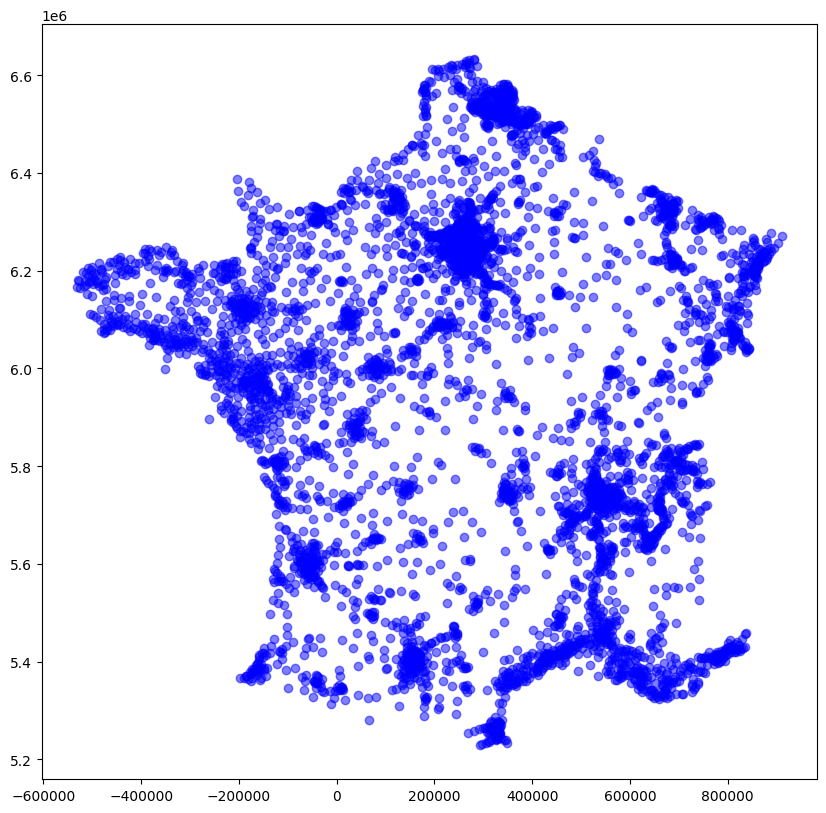

In [8]:
# Plot (only recommended if the city count is low)
fig, ax = plt.subplots(figsize=(10, 10))
cities_filtered.to_crs(epsg=mercator_epsg).plot(ax=ax, color='blue', alpha=0.5)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.show()

In [6]:
# Output to a GeoJson file
cities_filtered.to_crs(epsg=gps_epsg).to_file('./out/cities.geojson', driver='GeoJSON')

## VI. Building the distance matrix graph

At first, we thought that building a graph with the distances between all the cities was needed.
In reality, this computation is done in real time with the specified cities for the VRP.

Furthermore, this process is very inefficient. [It was optimized in the project](../backend/app/logic/vrp_tabu.py),
using numba for parallel GPU processing.

In [9]:
from tqdm.notebook import tqdm

graph = nx.Graph()
cities_nodes = cities_filtered.to_crs(epsg=mercator_epsg)
transformer = Transformer.from_crs(f'epsg:{mercator_epsg}', f'epsg:{gps_epsg}')

for i, city1 in tqdm(cities_nodes.iterrows(), total=len(cities_nodes), desc='Graph generation'):
    for j, city2 in cities_nodes.iterrows():
        if i == j or graph.has_edge(city1['INSEE_COMM'], city2['INSEE_COMM']):
            continue
        graph.add_node(city1['INSEE_COMM'], geometry=city1['geometry'])
        graph.add_node(city2['INSEE_COMM'], geometry=city2['geometry'])
        # Get the gps coordinates of the two cities as a tuple
        coords_1 = transformer.transform(city1['geometry'].y, city1['geometry'].x)
        coords_2 = transformer.transform(city2['geometry'].y, city2['geometry'].x)
        # Calculate the great circle distance between the two cities
        distance = great_circle(coords_1, coords_2).km
        graph.add_edge(city1['INSEE_COMM'], city2['INSEE_COMM'], weight=distance)

Graph generation:   0%|          | 0/5000 [00:00<?, ?it/s]

In [178]:
# Plot
fig, ax = plt.subplots(figsize=(10, 10))
pos = {node: (data['geometry'].x, data['geometry'].y) for node, data in graph.nodes(data=True)}
nx.draw(graph, pos, ax=ax, node_size=10, node_color='blue')
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.show()

In [10]:
# Distance matrix
distances = nx.floyd_warshall_numpy(graph)
# Save to CSV
pd.DataFrame(distances, index=graph.nodes, columns=graph.nodes).to_csv(f'./out/matrix-distances-{cities_count}.csv')